In [1]:
import sys
import os
import pathlib
sys.path.insert(0, '..')

import numpy as np

import control
import f16
import test_f16
import casadi as ca
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 10)

np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=200)

In [2]:
p0 = f16.Parameters(xcg=0.3) # listed as -0.3, must be typo
theta_dot = 0.3
x0 = f16.State(VT=502, alpha=0.3006, beta=4.1e-5, theta=0.3006, Q=0.3)
u0 = f16.Control(thtl=1.023, elv_deg=-7.082, ail_deg=-6.2e-4, rdr_deg=0.01655)
x0.power = f16.tables['tgear'](u0.thtl)
ss = f16.linearize(x0, u0, p0)
ss

A:
[[  -0.127 -234.742   -0.003    0.001  -32.17     0.       0.      -9.51     0.       0.       0.       0.       0.314]
 [  -0.001   -0.969    0.      -0.       0.       0.      -0.       0.908   -0.       0.       0.       0.      -0.   ]
 [   0.       0.      -0.322    0.061    0.       0.       0.298    0.      -0.948    0.       0.      -0.      -0.   ]
 [   0.       0.       0.       0.093    0.       0.       1.       0.       0.31     0.       0.       0.       0.   ]
 [   0.       0.       0.      -0.       0.       0.       0.       1.      -0.       0.       0.       0.       0.   ]
 [   0.       0.       0.       0.314    0.       0.       0.       0.       1.047    0.       0.       0.       0.   ]
 [  -0.      -0.002  -62.459    0.       0.       0.      -3.003    0.       1.991    0.       0.       0.       0.   ]
 [   0.001   -4.559    0.       0.       0.       0.       0.      -1.579   -0.003    0.       0.       0.       0.   ]
 [  -0.      -0.002    7.676    0.   

In [3]:
reduced_ss = ss.sub_system(x=['VT', 'alpha', 'theta', 'Q', 'power', 'beta', 'phi', 'P', 'R'], u=['thtl', 'elv_deg', 'ail_deg', 'rdr_deg']);
reduced_ss

A:
[[  -0.127 -234.742  -32.17    -9.51     0.314   -0.003    0.001    0.       0.   ]
 [  -0.001   -0.969    0.       0.908   -0.       0.      -0.      -0.      -0.   ]
 [   0.       0.       0.       1.       0.       0.      -0.       0.      -0.   ]
 [   0.001   -4.559    0.      -1.579    0.       0.       0.       0.      -0.003]
 [   0.       0.       0.       0.      -5.       0.       0.       0.       0.   ]
 [   0.       0.       0.       0.      -0.      -0.322    0.061    0.298   -0.948]
 [   0.       0.       0.       0.       0.       0.       0.093    1.       0.31 ]
 [  -0.      -0.002    0.       0.       0.     -62.459    0.      -3.003    1.991]
 [  -0.      -0.002    0.       0.003    0.       7.676    0.      -0.262   -0.629]]
B:
[[   0.      -0.244    0.       0.   ]
 [   0.      -0.002    0.       0.   ]
 [   0.       0.       0.       0.   ]
 [   0.      -0.199    0.       0.   ]
 [1086.9      0.       0.       0.   ]
 [   0.       0.       0.       0.001]
 [ 

# Longitudinal Subsystem

In [14]:
lon_ss = ss.sub_system(x=['VT', 'alpha', 'theta', 'Q', 'power'], u=['thtl', 'elv_deg'])
lon_ss

A:
[[  -0.127 -234.742  -32.17    -9.51     0.314]
 [  -0.001   -0.969    0.       0.908   -0.   ]
 [   0.       0.       0.       1.       0.   ]
 [   0.001   -4.559    0.      -1.579    0.   ]
 [   0.       0.       0.       0.      -5.   ]]
B:
[[   0.      -0.244]
 [   0.      -0.002]
 [   0.       0.   ]
 [   0.      -0.199]
 [1086.9      0.   ]]
C:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
D:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
dt:None
x:{'VT': 0, 'alpha': 1, 'theta': 2, 'Q': 3, 'power': 4}
u:{'thtl': 0, 'elv_deg': 1}
y:{'VT': 0, 'alpha': 1, 'theta': 2, 'Q': 3, 'power': 4}

In [15]:
np.linalg.eig(lon_ss.A)

(array([-1.277+1.968j, -1.277-1.968j, -0.06 +0.144j, -0.06 -0.144j, -5.   +0.j   ]),
 array([[-1.   +0.j   , -1.   -0.j   ,  1.   +0.j   ,  1.   -0.j   , -0.063+0.j   ],
        [-0.004+0.008j, -0.004-0.008j, -0.   -0.j   , -0.   +0.j   ,  0.   +0.j   ],
        [-0.   +0.008j, -0.   -0.008j, -0.002-0.004j, -0.002+0.004j, -0.   +0.j   ],
        [-0.016-0.012j, -0.016+0.012j,  0.001-0.j   ,  0.001+0.j   ,  0.   +0.j   ],
        [ 0.   +0.j   ,  0.   -0.j   ,  0.   +0.j   ,  0.   -0.j   ,  0.998+0.j   ]]))

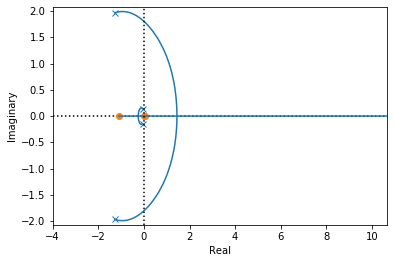

In [16]:
control.rlocus(lon_ss.sub_system(lon_ss.x, ['elv_deg'], ['Q']).to_control());

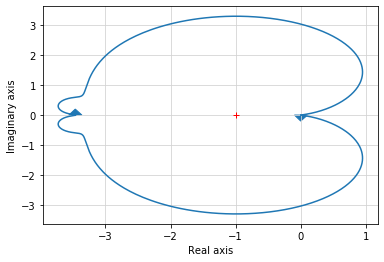

In [17]:
K = 100
G = K*ss.sub_system(lon_ss.x, ['elv_deg'], ['alpha']).to_control()
Gc = control.feedback(G, 1)


plt.figure()
control.nyquist(G, np.logspace(-4, 4, 1000));

Based on the above nyquist plot, what is N, the number of clockwise encirclements of -1?

Use this information and the poles of the open loop G (P), given below, to find the number
of unstable poles of the closed loop, which are the same as the zeros of the open loop (Z).

Z = N + P

In [18]:
control.pole(G)  # use to find P

array([-1.277+1.968j, -1.277-1.968j, -0.06 +0.144j, -0.06 -0.144j, -5.   +0.j   ])

Solution:

number of clockwise encirclements of -1: N = 1,
number of unstables poles of open loop: P = 0

number of unstables zeros of open loop: Z = 1

Therefore the number of unstable poles of the closed loop is Z, or 1. So the system is unstable.

In [19]:
control.pole(Gc)  # this tells you the answer

array([-4.944+0.j   ,  2.617+0.j   , -0.07 +0.144j, -0.07 -0.144j, -5.   +0.j   ])

Here we can verify that Z = 1, Gc has one unstable pole.

What simple change could be made to K to make the closed loop system stable?

<Figure size 432x288 with 0 Axes>

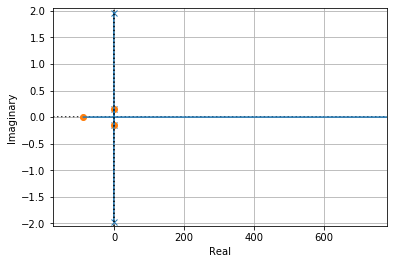

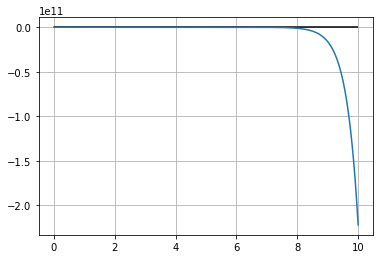

In [20]:
plt.figure()
control.rlocus(G);
plt.grid()

plt.figure()
t, y = control.step_response(Gc, T=np.linspace(0, 10, 1000));
plt.plot(t, y)
plt.hlines(1, 0, 10)
plt.grid()

# Lateral Subsystem

In [21]:
lat_ss = ss.sub_system(['beta', 'phi', 'P', 'R'], ['ail_deg', 'rdr_deg'])
lat_ss

A:
[[ -0.322   0.061   0.298  -0.948]
 [  0.      0.093   1.      0.31 ]
 [-62.459   0.     -3.003   1.991]
 [  7.676   0.     -0.262  -0.629]]
B:
[[ 0.     0.001]
 [ 0.     0.   ]
 [-0.645  0.126]
 [-0.018 -0.066]]
C:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
D:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
dt:None
x:{'beta': 0, 'phi': 1, 'P': 2, 'R': 3}
u:{'ail_deg': 0, 'rdr_deg': 1}
y:{'beta': 0, 'phi': 1, 'P': 2, 'R': 3}

In [22]:
np.linalg.eig(lat_ss.A)

(array([-1.02 +4.95j, -1.02 -4.95j, -1.893+0.j  ,  0.072+0.j  ]),
 array([[-0.034-0.073j, -0.034+0.073j, -0.008+0.j   ,  0.003+0.j   ],
        [-0.034-0.181j, -0.034+0.181j, -0.466+0.j   ,  0.998+0.j   ],
        [ 0.967+0.j   ,  0.967-0.j   ,  0.855+0.j   , -0.037+0.j   ],
        [-0.104+0.112j, -0.104-0.112j,  0.226+0.j   ,  0.051+0.j   ]]))

0 states have been removed from the model


<Figure size 432x288 with 0 Axes>

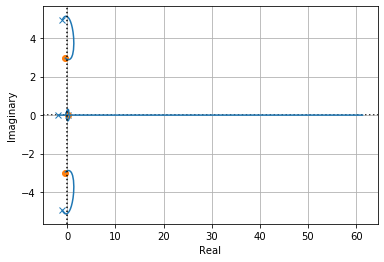

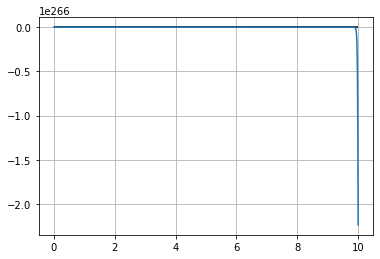

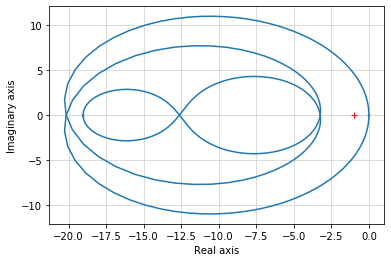

In [23]:
K2 = 100
G2 = K2*ss.sub_system(lat_ss.x, ['ail_deg'], ['P']).to_control();
G2c = control.minreal(control.feedback(G2, 1))

plt.figure()
control.rlocus(G2, kvect=np.linspace(0, 1, 100));
plt.grid()

plt.figure()
t, y = control.step_response(G2c, T=np.linspace(0, 10, 1000));
plt.plot(t, y)
plt.hlines(1, 0, 10)
plt.grid()

plt.figure()
control.nyquist(G2, np.logspace(-4, 4, 1000));